Load dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from IPython.display import display
from tqdm.notebook import tqdm
from torchsummary import summary
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
import glob
import albumentations as A
from albumentations.pytorch import ToTensor
from numpy import array
from numpy import argmax
import os
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torchvision import models
#plot confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import random
import seaborn as sns

def display_tensor(t):
  trans = transforms.ToPILImage()
  display(trans(t))

## Load all the images from google drive

In [ ]:
!mkdir '/content/img_patches'
!unrar x '/content/drive/MyDrive/Individual_Project/img.rar' '/content/img_patches'

In [ ]:
# learn the knowledge about python class
class custom(torch.utils.data.Dataset):
  
  def __init__(self, img_dir, img_names):
    
    super().__init__()
    
    # store directory names
    self.img_dir = img_dir
    # use glob to get all image names
    self.img_names = img_names
    self.transforms = ToTensor()

  def __len__(self):
    return len(self.img_names)
    
  def __getitem__(self,i):
    return self._read_img_and_gt(i)
  
  def _read_img_and_gt(self, i):
    im=self.img_names[i]
    img = cv2.imread(self.img_dir + "/" + self.img_names[i])
    labels=im[0]

    if labels=='A':
        labels=0
    elif labels=='B':
        labels=1
    elif labels=='C':
        labels=2        
    return self.transforms(image=img,labels=labels)
  

In [ ]:
# set images folder path
path="/content/img_patches/img"

In [ ]:
# Get all the images name
Images_name = []
for x in glob.glob("/content/img_patches/img/*"):
  Images_name.append(x.split('/')[4])
Images_name[0]

'A250.png'

In [ ]:
# Split dataset into training and test dataset
X_train, X_test = train_test_split(Images_name,test_size=0.3, random_state=42)

In [ ]:
train = custom(path,X_train)
test = custom(path,X_test)

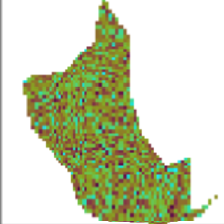

2

In [ ]:
display_tensor(train[0]["image"])
train[0]['labels']

### Neural Network

#### VGG16 Pre trained model

In [ ]:
#vgg16 = models.vgg16(pretrained=True)
#inception = models.inception_v3(pretrained=True)
# here we can try to use different model to test the model or to classify the images

In [ ]:
def VGG16(pretrained=True, num_classes=3, add_softmax=True):
  # get the pretrianed model(including the weights)
  vgg16 = models.vgg16(pretrained=pretrained)
  # don't change the existing parameters
  for param in vgg16.features.parameters():
    param.requires_grad = False
  # change the output layer
  vgg16.classifier[6]=nn.Linear(4096,num_classes) #Adding softmax and changing the number of classes
  if add_softmax:
    vgg16.classifier.add_module("7",nn.LogSoftmax(dim=1))
  return vgg16

In [ ]:
model = VGG16(pretrained=True, num_classes=3, add_softmax=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
# test if the model works 
x = torch.randn([3,224,224])
model(x.unsqueeze(0))

tensor([[-0.6966, -1.3693, -1.3965]], grad_fn=<LogSoftmaxBackward>)

## Build VGG16 by yourself

In [ ]:
#VGG16 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'] 
VGG_types =  {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
class VGG16_Local(nn.Module):
  def __init__(self, in_channels = 3, num_classes = 3):
    super(VGG16_Local, self).__init__()
    self.in_channels = in_channels

    self.conv_layers = self.create_conv_layer(VGG_types['E'])

    self.fcs = nn.Sequential(
        nn.Linear(512*7*7, 4096),
        nn.ReLU(),# nn.ReLU(True)
        nn.Dropout(p = 0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(p = 0.5),
        nn.Linear(4096, num_classes),

        nn.LogSoftmax(dim=1)
    )
    
  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(x.shape[0], -1)
    x = self.fcs(x)

    return x

  def create_conv_layer(self, architecture):
    layers = []
    in_channels = self.in_channels

    for x in architecture:
      if type(x) == int:
        out_channels = x

        layers += [nn.Conv2d(in_channels=in_channels, out_channels= out_channels,
                             kernel_size = (3,3), stride = (1,1), padding = (1,1)),
                   nn.BatchNorm2d(x),#improve performance
                   nn.ReLU()]
        in_channels = x
      elif x == 'M':
        layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
    
    return nn.Sequential(*layers)

In [ ]:
model_local = VGG16_Local()

In [ ]:
x = torch.randn([3,224,224])
model_local(x.unsqueeze(0))

tensor([[-1.1444, -0.9710, -1.1944]], grad_fn=<LogSoftmaxBackward>)

## Training loop

In [ ]:
def train_model(model,train, N_EPOCHS=5):

  criterion = nn.NLLLoss()  #negative log likelihood
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  SAMPLES_TO_USE = 500

  N_EPOCHS = N_EPOCHS
  #move model to cuda()
  model.cuda()
  model.train()

  for e in range(N_EPOCHS):
    print("EPOCH:",e)
    
    running_loss = 0
    running_accuracy = 0
    
    for i in tqdm(range(SAMPLES_TO_USE)):
      
    
      sample = train[i] 
      # move the inputs into cuda
      x = sample["image"].unsqueeze(0).cuda()  
      label = torch.tensor([sample["labels"]]).cuda() 

      y=model(x)    
      # calculate the loss
      loss = criterion(y,label)  
      # Sets the gradients of all optimized torch.Tensor s to zero.
      optimizer.zero_grad() 
      # backpropagation
      loss.backward()
      # optimizer.step is performs a parameter update based on the current gradient
      optimizer.step() 
      running_loss += loss.data 
      running_accuracy += 1 if y.max(1)[1] == label else 0
      
    print("Training accuracy:", running_accuracy/SAMPLES_TO_USE)  #accuracy
    print("Training loss:", running_loss/SAMPLES_TO_USE) #training loss

In [ ]:
# Here we need add validation set to identify if overfit
# add other metrics 
train_model(model,train,5)

EPOCH: 0



Training accuracy: 0.916
Training loss: tensor(9.7967, device='cuda:0')
EPOCH: 1



Training accuracy: 0.9
Training loss: tensor(13.0221, device='cuda:0')
EPOCH: 2



Training accuracy: 0.936
Training loss: tensor(9.2083, device='cuda:0')
EPOCH: 3



Training accuracy: 0.926
Training loss: tensor(12.2932, device='cuda:0')
EPOCH: 4



Training accuracy: 0.932
Training loss: tensor(13.0065, device='cuda:0')


In [ ]:
train_model(model_local,train,2)

EPOCH: 0



Training accuracy: 0.336
Training loss: tensor(7.4110, device='cuda:0')
EPOCH: 1



Training accuracy: 0.341
Training loss: tensor(1.1881, device='cuda:0')


## Test

In [ ]:
def eval_model(model, test):
  # set the model into evaluate mode
  model.eval()
  criterion = nn.NLLLoss()  #negative log likelihood
  
  test_loss = 0
  test_accuracy = 0
  y_pred = []
  y_test = []

  for i in tqdm(range(len(X_test))):
    # Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). 
    # It will reduce memory consumption for computations that would otherwise have requires_grad=True.
    with torch.no_grad():
      
      sample = test[i]  
      x = sample["image"].unsqueeze(0)
      label = torch.tensor([sample["labels"]])

      # move the batch to GPU
      x = x.cuda()
      label = label.cuda()

      # Compute the network output
      y = model(x)

      # Compute the loss
      loss = criterion(y, label)

      test_loss += loss.item()
      test_accuracy += (y.max(1)[1] == label).sum().item()
      y_pred.append(int(y.max(1)[1]))
      y_test.append(int(label))

  print("Test accuracy:", test_accuracy/float(len(X_test)),
        "Test loss:", test_loss/float(len(X_test)))
  return y_test, y_pred

In [ ]:
y_test, y_pred = eval_model(model,test)


Test accuracy: 0.8866666666666667 Test loss: 16.254130821170044


In [ ]:
y_test_local, y_pred_local = eval_model(model_local,test)


Test accuracy: 0.33444444444444443 Test loss: 1.1388191537724601


## Confusion Matrix

In [ ]:
def draw_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, cbar=False, fmt='g')
  plt.xlabel("predicted")
  plt.ylabel("true")

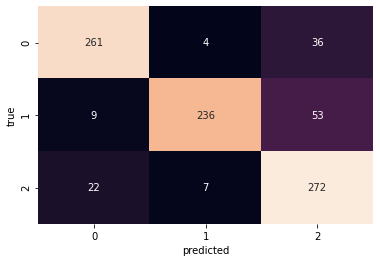

In [ ]:
draw_confusion_matrix(y_test, y_pred)

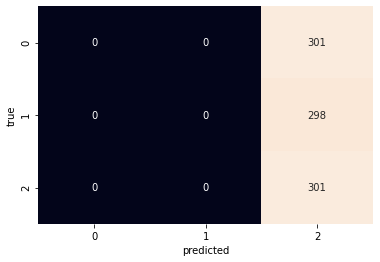

In [ ]:
draw_confusion_matrix(y_test_local, y_pred_local)

### Test Randomly

In [ ]:
def random_test(model, data):

  for i in range(5):
    n = random.randint(0, len(data)) #random images
    
    sample = data[n]

    x = sample["image"].unsqueeze(0)

    label = torch.tensor([sample["labels"]])

    x = x.cuda()
    label = label.cuda()

    display_tensor(sample["image"])#display tensor method

    y_pred = model(x).max(1)[1]

    print("Expected output:", int(label))
    print("Network output:", int(y_pred))

    if y_pred == label:
      print("Success")
    else:
      print("Fail")

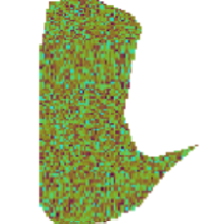

Expected output: 2
Network output: 2
Success


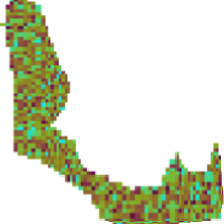

Expected output: 0
Network output: 0
Success


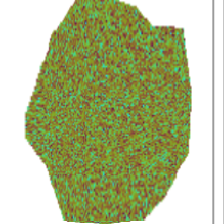

Expected output: 0
Network output: 0
Success


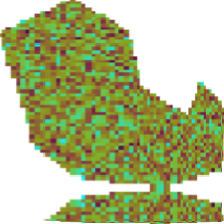

Expected output: 0
Network output: 0
Success


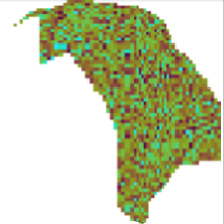

Expected output: 2
Network output: 2
Success


In [ ]:
random_test(model, test)

## Save and load  model

In [ ]:
# Specify a path
PATH = "/content/drive/MyDrive/Individual_Project/VGG_pretrained/VGG_pretrained.pt"
torch.save(model, PATH)

In [ ]:
# Load
model_loaded = torch.load(PATH)
model_loaded.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
x = torch.randn([3,224,224])
model_loaded(x.unsqueeze(0).cuda())

tensor([[   0.0000, -376.0202, -154.1816]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)